The optimal angle is:  55  degrees


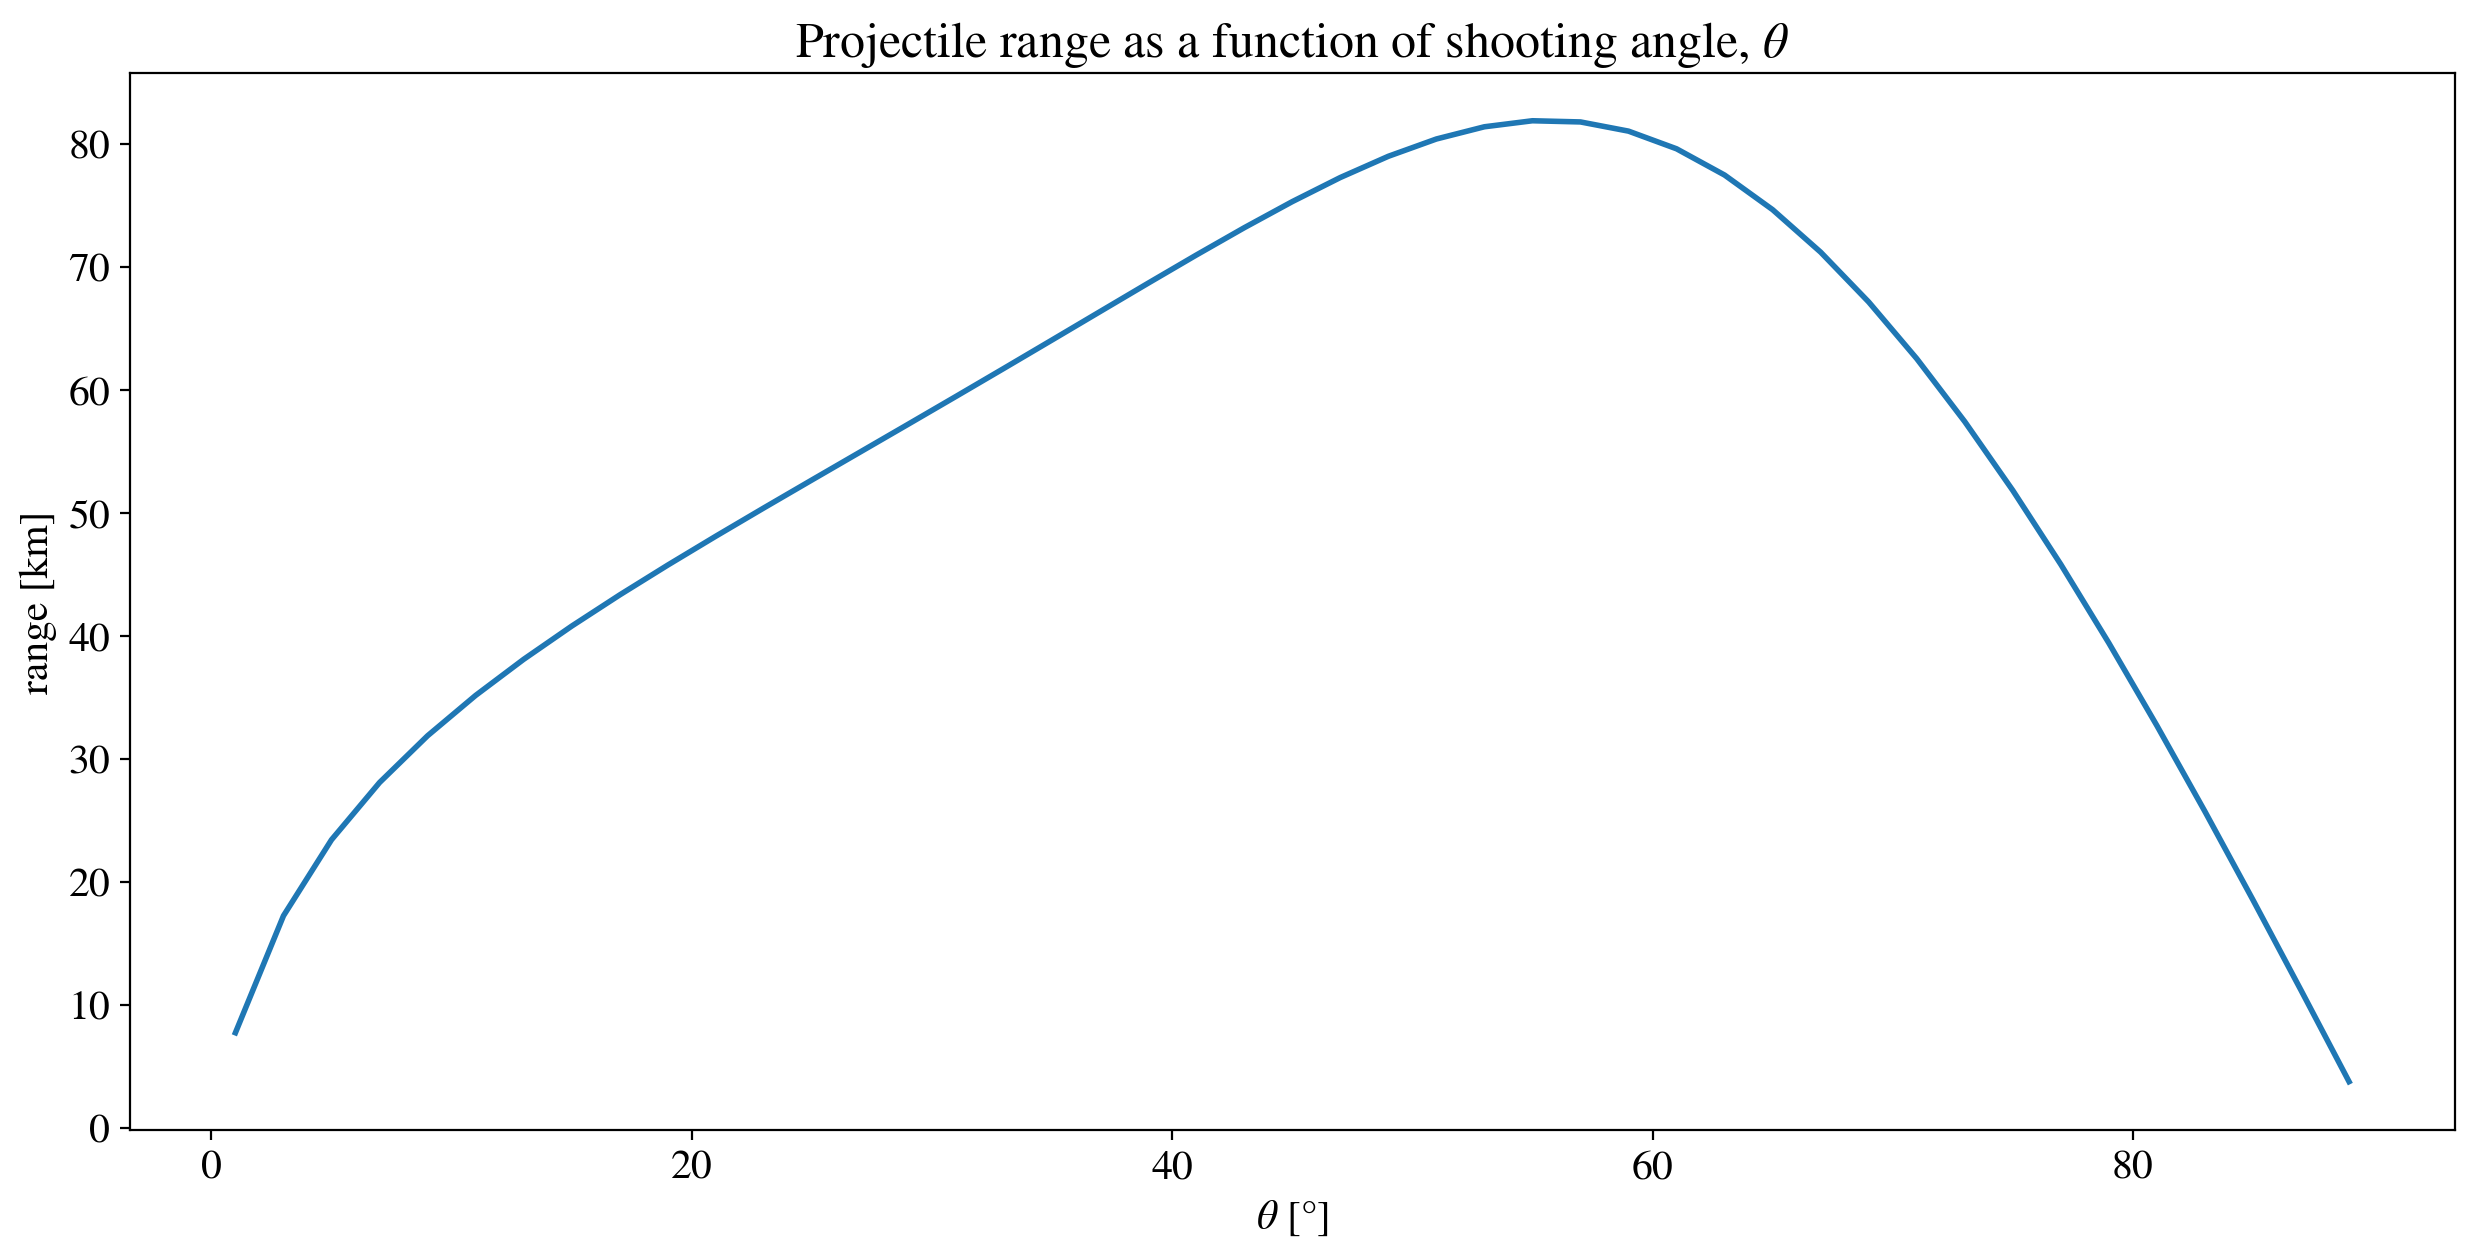

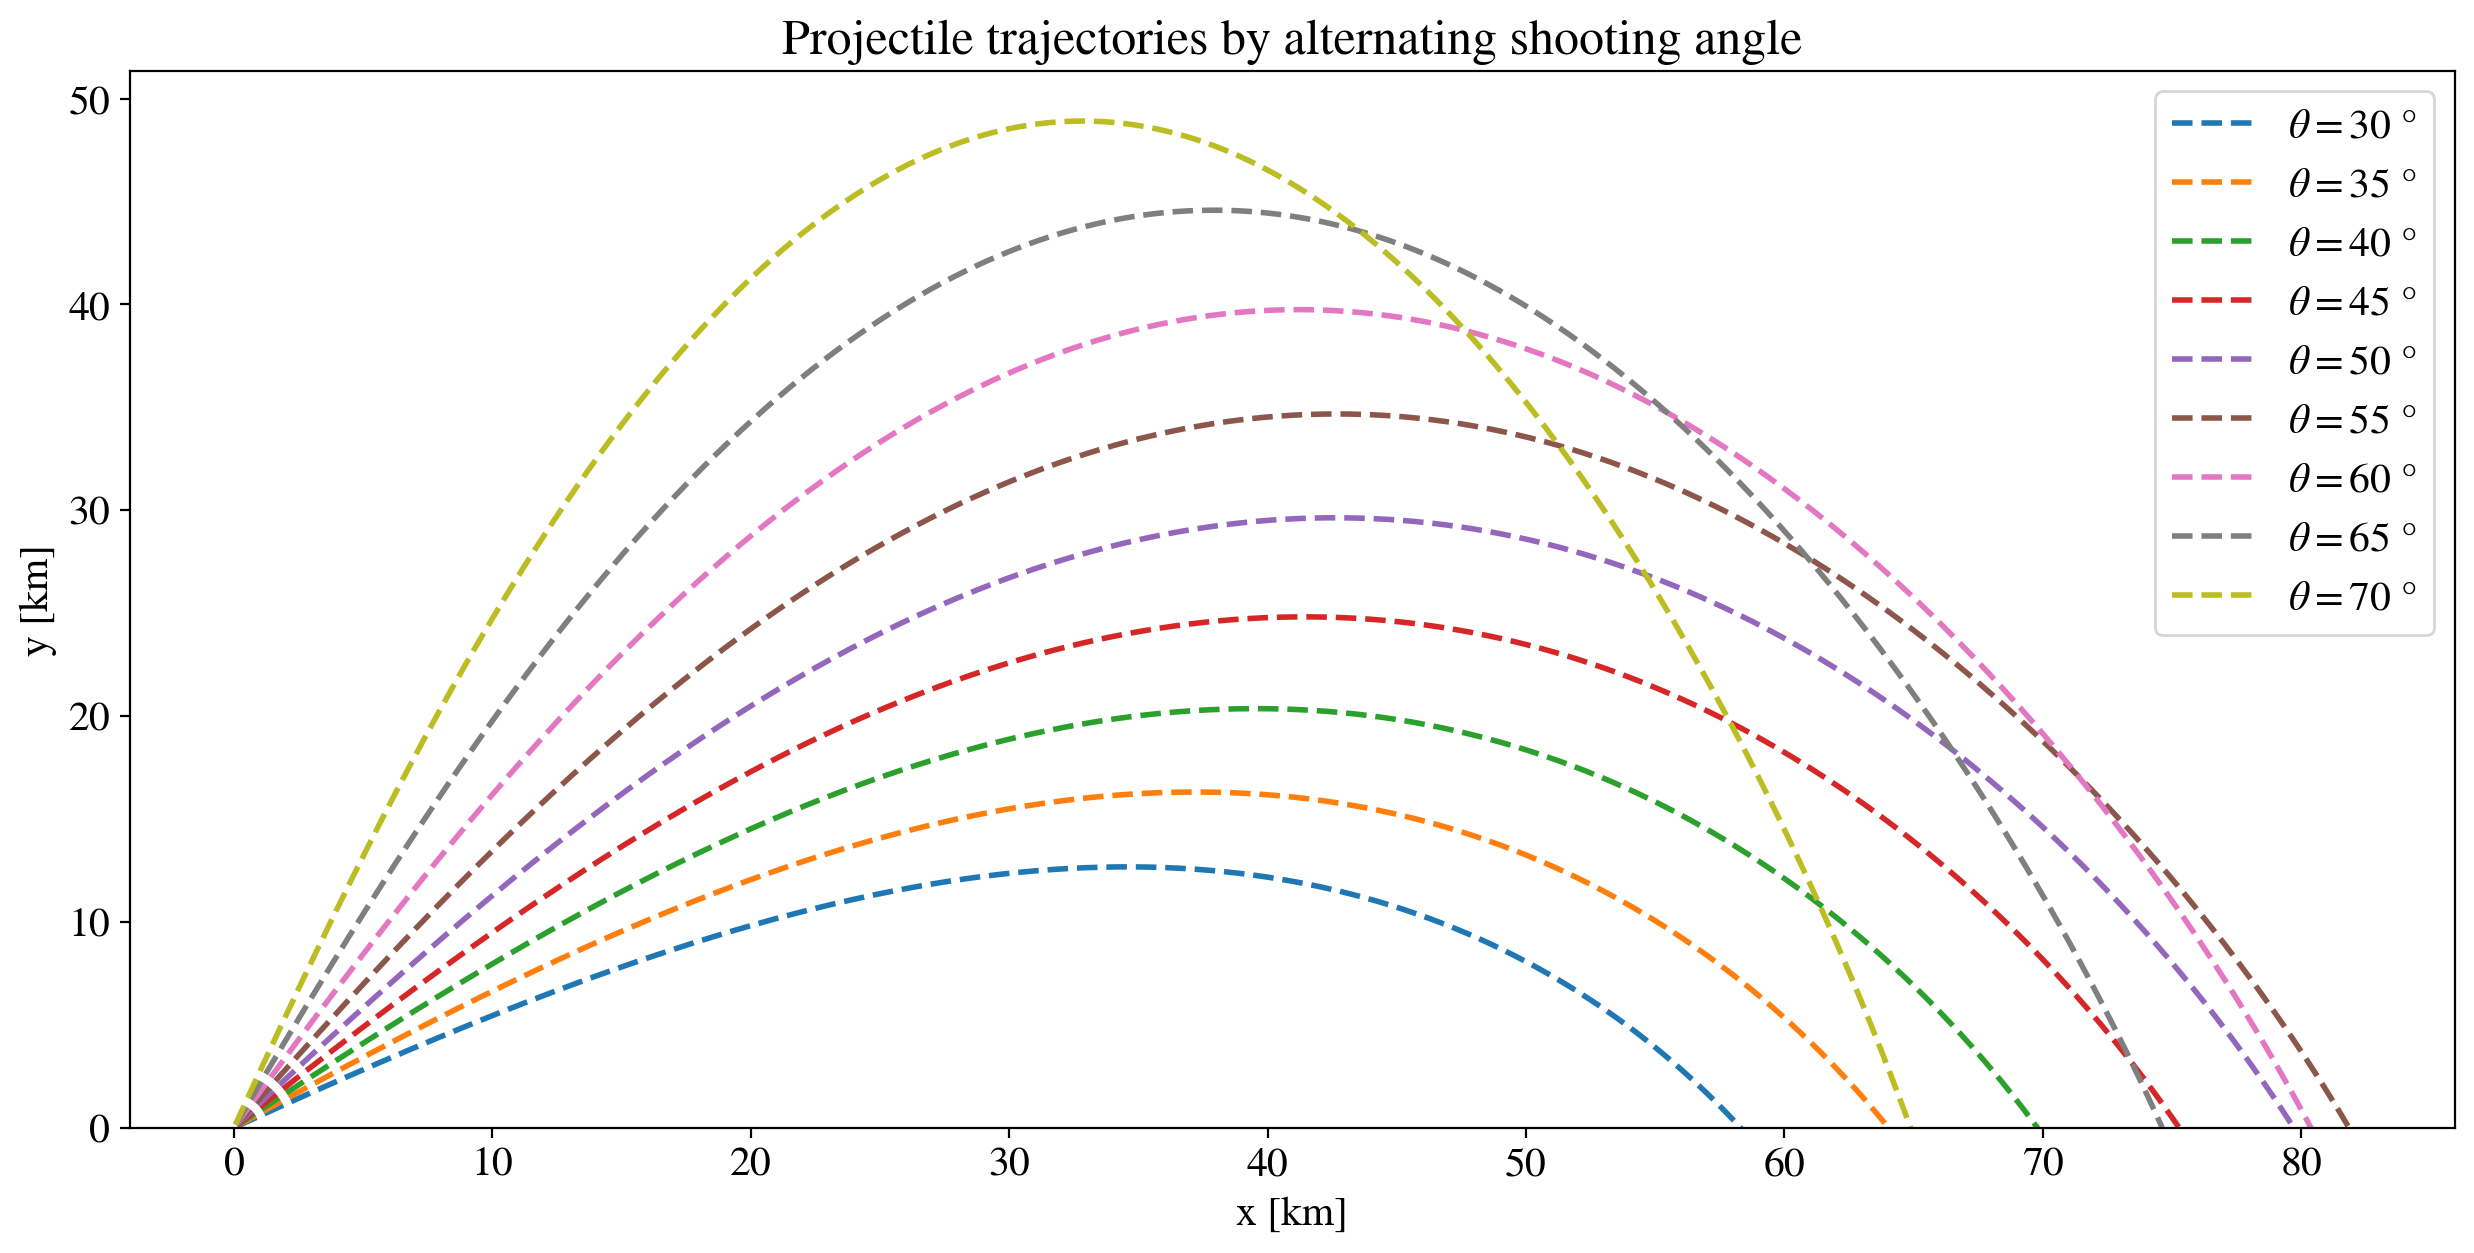

At firing angle 45.0 degrees and with time step h = 0.10 seconds:
Energy lost with RK4: -7.395E+03 = -0.01 percent of total energy
Energy lost with Euler's method: 2.735E+05 = 0.41 percent of total energy


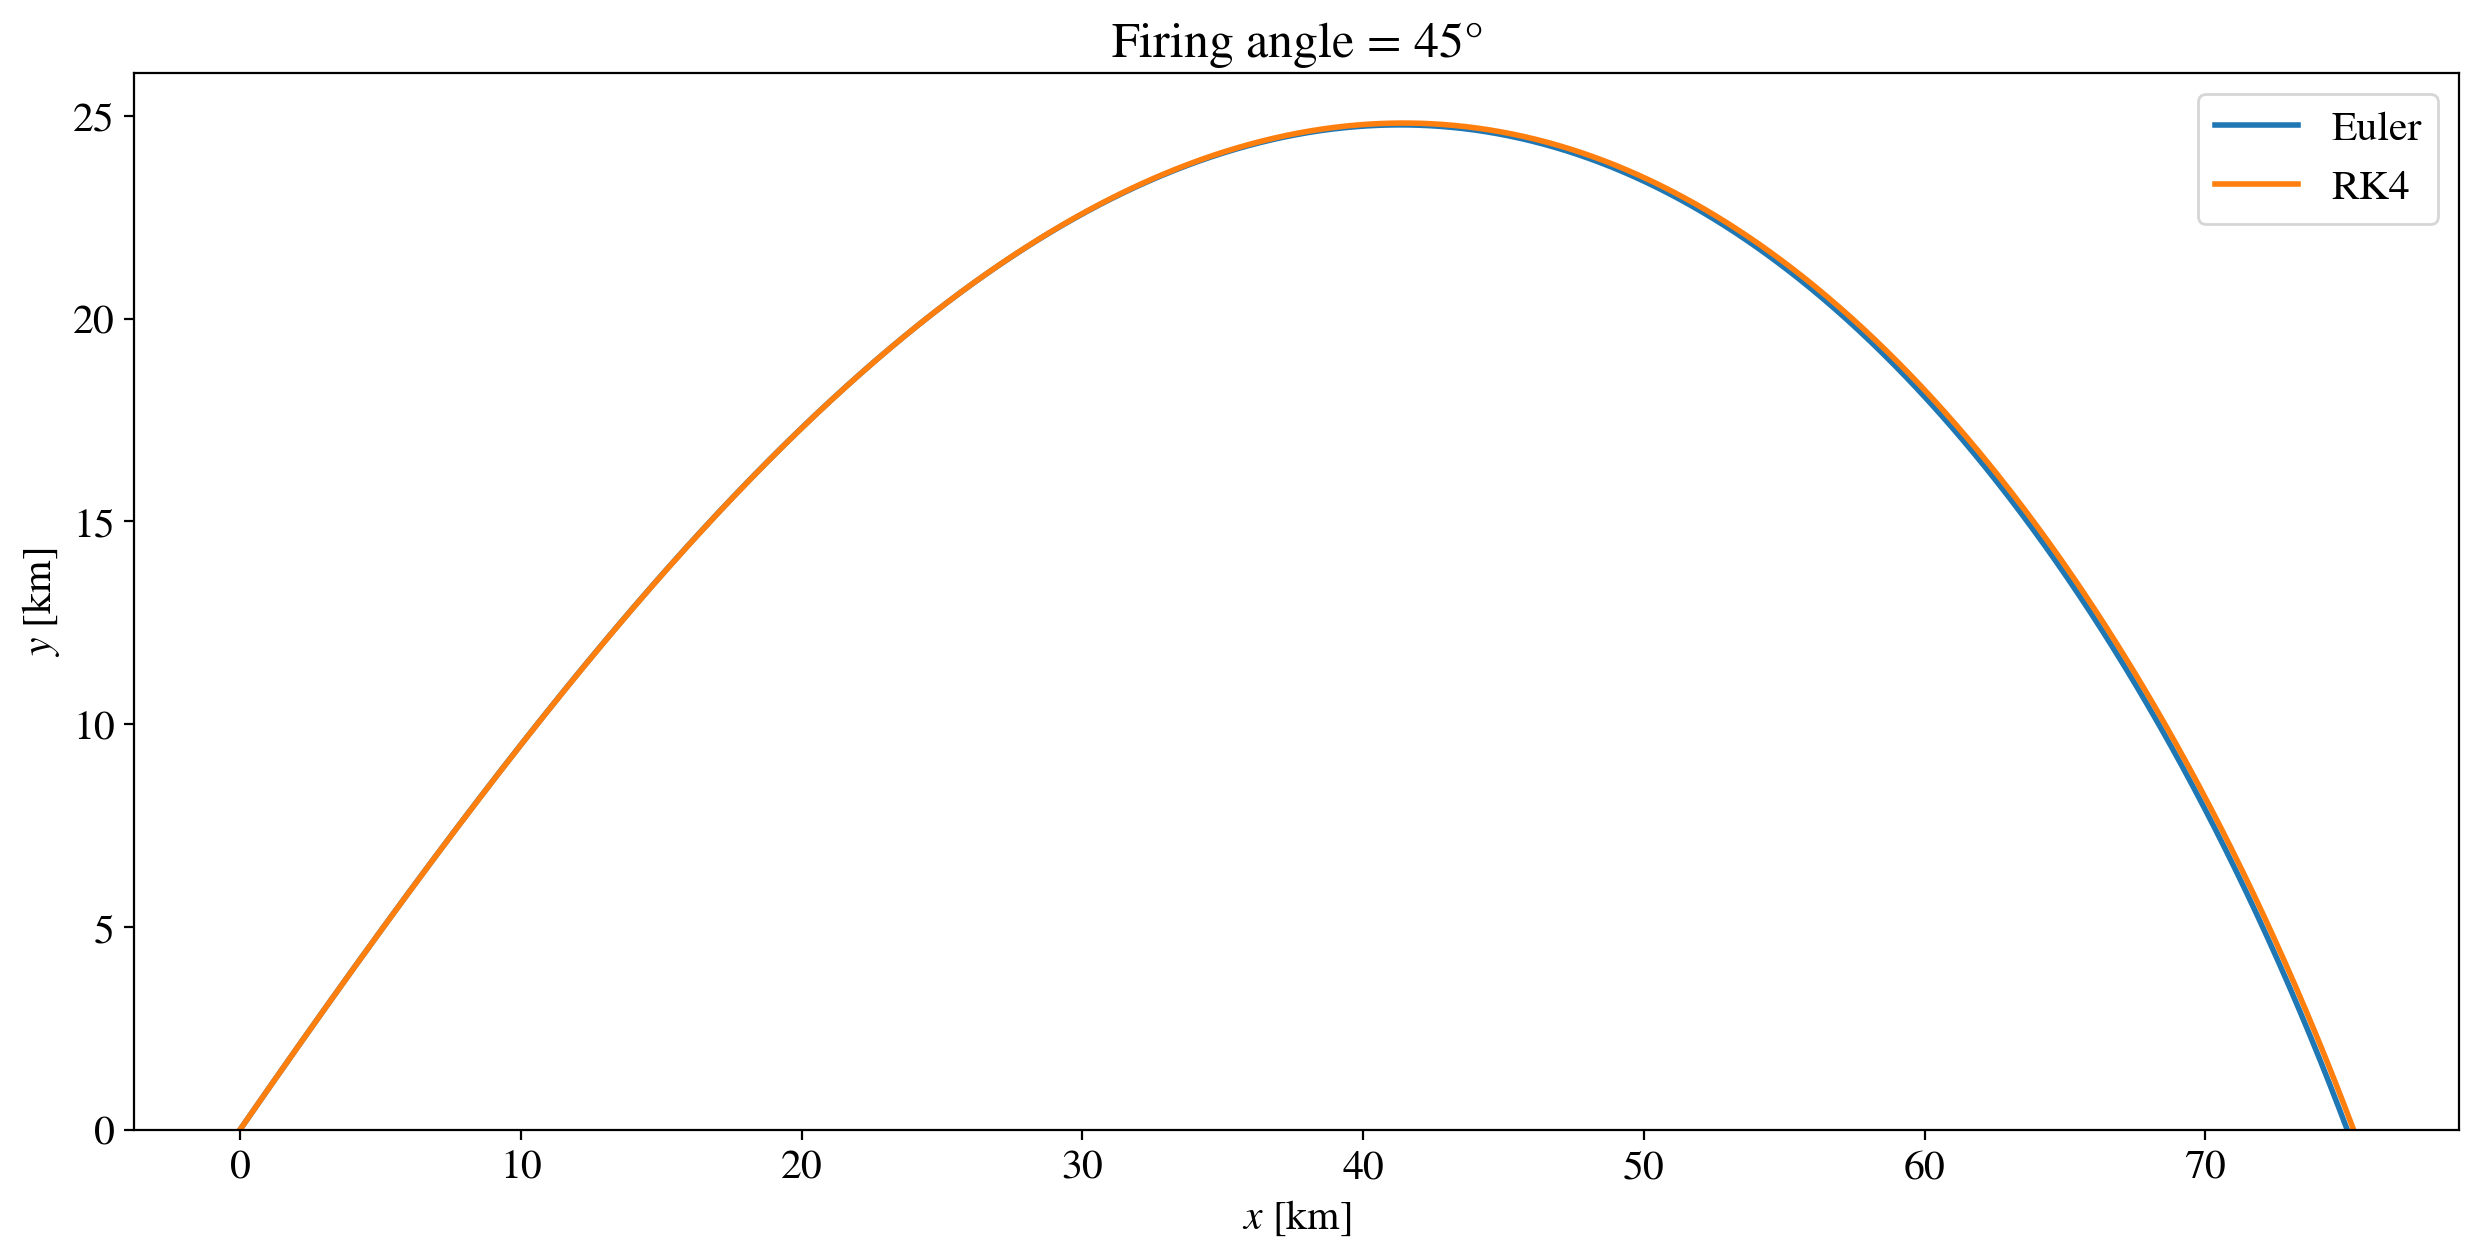

In [3]:
 # Importing necessary packages
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import rc
    %matplotlib inline

    newparams = {'figure.figsize': (15, 7), 'axes.grid': False,
                'lines.markersize': 10, 'lines.linewidth': 2,
                'font.size': 15, 'mathtext.fontset': 'stix',
                'font.family': 'STIXGeneral', 'figure.dpi': 200}
    plt.rcParams.update(newparams)

    # Constants

    g = 9.81             # Force of gravity per kilo on earth's surface
    alpha = 2.5          # Parameter in the adiabatic air density model
    a = 6.5 * 10 ** (-3) # Parameter in the adiabatic air density model
    T_0 = 288            # Temperature at sea level
    m = 50               # Mass of the projectile
    B = 2 * 10 ** (-3)   # Constant based on the Paris gun
    v_0 = 1640           # Initial velocity


    # Wind strength. This is a constant that never varies 
    V = np.zeros(2) # Starting of with no wind


    def f(w):
        """ A function describing the right hand side of the equations
        of motion/the set of ODEs.
        Parameter:
            w       vector containg the needed coordinates and their velocities 
        """
        # V : the vector describing the wind strength and direction
        temp_vector = np.zeros(4)
        temp_vector[0] = w[2]
        temp_vector[1] = w[3]
        # Saving the next parameters in order to optimize run time
        k = (1 - a * w[1] / T_0)   # Air density factor
        s = np.sqrt((w[2]-V[0]) ** 2 + (w[3]-V[1]) ** 2 )
        if k>0:
            temp_vector[2] = - B / m * k ** (alpha) * (w[2]-V[0]) * s
            temp_vector[3] = - B / m * k ** (alpha) * (w[3]-V[1]) * s - g
        else:
            temp_vector[2] = 0 
            temp_vector[3] = - g
        return temp_vector 


    def RK4_step(f, w, h):
        """Performing a single step of the Runge-Kutta fourth order method.
        Parameters:
            f      RHS of ODEs to be integrated
            w      numerical approximation of w at time t
            h      unit/integration step length
        Returns:
            numerical approximation of w at time t+h
        """
        s1 = f(w)
        s2 = f(w + (h / 2) * s1)
        s3 = f(w + (h / 2) * s2)
        s4 = f(w + h * s3)
        return w + (h / 6) * (s1 + (2 * s2) + (2 * s3) + s4)
    def shoot(theta, v0):
        """ Initializes the vector w (x and y position and velocity of the
        projectile) given a initial shooting angle, theta, and 
        absolute velocity, v0. 
        """
        w = np.zeros(4)
        w[2] = v0 * np.cos(np.deg2rad(theta))
        w[3] = v0 * np.sin(np.deg2rad(theta))
        return w


    def projectile_motion(h, theta):
        """ Calculates the motion of the projectile using the functions
        defined above. While the projectile is in the air (w[1] >=0) the 
        position and velocity is updated using a single step of RK4.
        Parameters:
            h        unit/integration step length
            theta    initial shooting angle
        Returns:
            X_list   array of the projectile's x-position
            Y_list   array of the porjectile's y-position
        """
        w = shoot(theta, v_0)
        X_list = np.zeros(0)
        Y_list = np.zeros(0)
        while  w[1] >= 0:
            w = RK4_step(f, w, h)
            X_list = np.append(X_list, w[0])
            Y_list = np.append(Y_list, w[1])
        return X_list, Y_list
    def find_optimal_angle(h):
        """ Given an integration time step, this function calculates the optimal initial 
        shooting angle for the projectile to obtain maximum range, in x-direction. The 
        set of angles tested, with their corresponding range, along with the optimal
        angle are returned.
        """
        
        record = 0        # Placeholder variable that holds the maximum range
        optimal_angle = 0 # Placeholder variable that holds the angle yielding the maximum range
        # Lists containing the initial angle and its corresponding range
        theta_list = np.zeros(0) 
        range_list = np.zeros(0)
        for theta in range (1,90,2):
            x_list, y_list = projectile_motion(h, theta)
            # Using linear interpolation do determine the landing point more precisely
            m = (y_list[-1] - y_list[-2]) / (x_list[-1] - x_list[-2])   # The landing point
            x_range = - y_list[-1] / m + x_list[-1] 
            theta_list = np.append(theta_list, theta)
            range_list = np.append(range_list, x_range)
            # Update records
            if x_range >= record:
                record = x_range
                optimal_angle = theta

        # Rerunning the same code on a smaller interval in order to approximate the optimal angle
        # more precicely
        theta_list_smaller = np.linspace(optimal_angle - 2, optimal_angle + 2, 41)
        for theta_small in theta_list_smaller:
            x_list, y_list = projectile_motion(h, theta)
            # Again, using linear interpolation do determine the landing point more precisely
            m = (y_list[-1] - y_list[-2]) / (x_list[-1] - x_list[-2])
            x_range = - y_list[-1] / m + x_list[-1]
            if x_range >= record:
                record = x_range
                optimal_angle = theta_small
                
        return theta_list, range_list, optimal_angle

    theta, x , best = find_optimal_angle(0.1)

    print("The optimal angle is: ", best, " degrees")

    plt.plot(theta, x/1000)
    plt.title(r"Projectile range as a function of shooting angle, $\theta$")
    plt.xlabel(r"$\theta $ [$\degree$]")
    plt.ylabel(r"range [km]")

    def trajectories(h):
        plt.figure()
        plt.title("Projectile trajectories by alternating shooting angle")
        plt.xlabel(r"x [km]")
        plt.ylabel(r"y [km]")
        theta_list = np.arange(30.0,75,5)
        for angle in theta_list:
            x_list, y_list = projectile_motion(h, angle)
            plt.plot(x_list/1000, y_list/1000, '--', label=r'$\theta = $%.i $\degree$'%(angle))
        plt.legend(loc='best')
        plt.gca().set_ylim(bottom=0)
        plt.show()
    trajectories(0.1)

    def euler_step(f ,w ,h):
        """Simple implementation of Euler's method on vector form
        """
        return w + h * f(w)

    def energy_conservation(h, theta, func):
        """ This function performs the same steps as "projectile_motion()" and "f()"
        but extracts the value for the drag, F_D, at every step. This enables the 
        calculation of work and storage of energy at each time step.
        Parameters:
            h           integration time step
            theta       initial shooting angle
            func        a function defining the integration step (euler or RK4)
        Returns:
            x_list      array of the trajectory x-coordinates
            y_list      array of the trajectory y-coordinates
            time_steps  array of the elapsed time at each step
            energy      array of the energy at each step
            work        the total work by the drag force
        """
        w = shoot(theta, v_0)
        
        x_list = np.zeros(1)
        y_list = np.zeros(1)
        work = 0
        
        # Initial total energy
        v = np.sqrt(w[2] ** 2 + w[3] ** 2)
        energy = np.array([0.5 * m * v ** 2])
        
        
        while w[1] >= 0:
            w = func(f, w, h)
            
            # Updating lists
            x_list = np.append(x_list, w[0])
            y_list = np.append(y_list, w[1])
            
            # Temporary parameters for checking if high altitude
            k = (1 - a * y_list[-2] / T_0)
            s = np.sqrt((w[2] - V[0]) ** 2 + (w[3] - V[1]) ** 2)
            if k > 0:
                F_D = B * k ** (alpha) * s ** 2
            else:
                F_D = 0
            
            # Add the amount of work done by drag this time interval
            work +=  v * F_D * h
            # Updating the speed in order to calculate the total energy
            v = np.sqrt(w[2] ** 2 + w[3] ** 2)
            # Use np.sum on the work_list to get the cumulative work
            energy = np.append(energy, 0.5 * m * v ** 2 + m * g * w[1] + work)
        
        n = len(x_list)
        time_steps = np.linspace(0, n * h, n)
        
        return x_list, y_list, time_steps, energy, work
    

    # Setting initial values
    theta = 45
    h = 0.1
    # Getting the results
    x_list_euler, y_list_euler, time_steps_euler, energy_euler, work = energy_conservation(h, theta, euler_step)
    x_list_RK4, y_list_RK4, time_steps_RK4, energy_RK4, work = energy_conservation(h, theta, RK4_step)

    print("At firing angle %.1f degrees and with time step h = %.2f seconds:" %(theta, h))
    print("Energy lost with RK4: %.3E = %.2f percent of total energy" %(energy_RK4[0] - energy_RK4[-1],
                                            (energy_RK4[0] - energy_RK4[-1]) / energy_RK4[0] * 100))
    print("Energy lost with Euler's method: %.3E = %.2f percent of total energy" %(energy_euler[0] - energy_euler[-1],
                                            (energy_euler[0] - energy_euler[-1]) / energy_euler[0] * 100))

    # Plotting the separate trajectories 
    plt.plot(x_list_euler/1000, y_list_euler/1000, label ="Euler")
    plt.plot(x_list_RK4/1000, y_list_RK4/1000, label ="RK4")
    plt.title("Firing angle = " + str(theta) + "$\degree$")
    plt.xlabel(r"$x$ [km]")
    plt.ylabel(r"$y$ [km]")
    plt.gca().set_ylim(bottom=0)
    plt.legend()
    plt.show()